# Decision Trees

1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children


[<__main__.Node at 0x7fca8b02c590>, <__main__.Node at 0x7fca8b02c610>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')


One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
#############################################################################
# TODO: Find the columns with missing values and remove them from the data.#
#############################################################################
data.dropna(axis=1,inplace=True)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`.

In [8]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    last_col = data[:,-1]
    col_freq = pd.Series(last_col).value_counts(normalize=True)
    for value in col_freq.values:
          gini += value ** 2
    gini = 1-gini
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return gini

In [9]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    last_col = data[:,-1]
    col_freq = pd.Series(last_col).value_counts(normalize=True)
    for value in col_freq.values:
          entropy += value  * np.log2(value)
    entropy = -entropy
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return entropy

In [10]:
##### Your Tests Here #####
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

In our implementation the goodness_of_split function will return either the Goodness of Split or the Gain Ratio as learned in class. You'll control the return value with the `gain_ratio` parameter. If this 


parameter will set to False (the default value) it will return the regular Goodness of Split. If it will set to True it will return the Gain Ratio.
$$
GainRatio(S,A)=\frac{InformationGain(S,A)}{SplitInformation(S,A)}
$$
Where:
$$
InformationGain(S,A)=Goodness\ of\ Split\ calculated\ with\ Entropy\ as\ the\ Impurity\ function \\
SplitInformation(S,A)=- \sum_{a\in A} \frac{|S_a|}{|S|}\log\frac{|S_a|}{|S|}
$$
NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch).

In [11]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split (or the Gain Ration).  
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    goodness = 0
    values, counts = np.unique(data[:,feature], return_counts=True)
    size = len(data[:,feature])
    #gain ratio
    if gain_ratio:
       info_gain = goodness_of_split(data, feature, impurity_func, False)
       split_info = -1 * sum(counts * np.log2(counts/size)) / size
       goodness = info_gain / split_info

    #goodness of split
    else:
      for index, val in enumerate (values):
        proportional_size = counts[index]/size
        filtered_inst = data[data[:,feature]==val]
        goodness -= proportional_size * impurity_func(filtered_inst)
      goodness += impurity_func(data)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return goodness    

In [12]:
print(goodness_of_split(data=X_train,feature=0,impurity_func=calc_gini,gain_ratio=True))
print(goodness_of_split(data=X_train,feature=0,impurity_func=calc_entropy,gain_ratio=True))
print(goodness_of_split(data=X_train,feature=0,impurity_func=calc_entropy,gain_ratio=False))
print(goodness_of_split(data=X_train,feature=0,impurity_func=calc_gini,gain_ratio=False))

0.010883560598699616
0.016696903686886814
0.027475652034306686
0.017909483669059645


## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class.

In [13]:
def chi_square_calculation(data, feature):
    chi_square = 0 
    labels, counts = np.unique(data[:,-1], return_counts=True)
    feature_values, feature_values_counts = np.unique(data[:, feature], return_counts=True)
    p_y0 = counts[0] / len(data)
    p_y1 = counts[1] / len(data)
    
    for value in range(len(feature_values)):
        df = feature_values_counts[value]
        e_0 = df * p_y0
        e_1 = df * p_y1   
        pf = len(np.where((data[:,feature] ==  feature_values[value]) & (data[:,-1] == labels[0]))[0])
        nf = len(np.where((data[:,feature] ==  feature_values[value]) & (data[:,-1] == labels[1]))[0])
        
        chi_square += pow((pf - e_0),2)/e_0 + pow((nf - e_1),2)/e_1
        
    return chi_square

In [14]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    def __init__(self, feature,predict, children_opt,edi_pois):
        self.feature = feature # column index of criteria being tested
        #prediction by majority class
        self.predict = predict
        #children dictionary- key= branch value, value = child node
        self.children = {}
        self.children_opt = children_opt
        self.class_values,self.class_counts = edi_pois
        
    def count_nodes_of(self):
        counter = 0
        for child in self.children.values():
          counter += child.count_nodes_of() + 1 
        return counter



In [15]:
def build_tree(data, impurity, gain_ratio=False, chi=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - chi: chi square p-value cut off (1 means no pruning)
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    current_depth=0
    root = recursive_build_tree(data, impurity, gain_ratio, chi, current_depth, max_depth,[])
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return root

In [16]:
def recursive_build_tree(data, impurity, gain_ratio, chi, current_depth, max_depth,used_attr):
    #initial values
    best_feat_index = -1
    best_feat_goodness = np.NINF
    edi_pois= diff_classes,counts = np.unique(data[:,-1],return_counts=True)
    pred = diff_classes[counts.argmax()]
    # base case- Purity reached \ reached max depth
    if len(np.unique(data[:,-1])) == 1 or current_depth == max_depth: 
      return DecisionNode(None,data[0,-1],None,edi_pois)

    #finding the greatest gain possible
    for feat in range(len(data[0])-1):
      #if already used certain attribute, move to next iteration
      if feat in used_attr:
        continue
      can_goodness = goodness_of_split(data,feat,impurity, gain_ratio)

      #if found new best candidate
      if can_goodness > best_feat_goodness:
        best_feat_index = feat
        best_feat_goodness = can_goodness

    #predict according to majority class
    possible_values = np.unique(data[:,best_feat_index]) 
    if  chi != 1:
        chi_square = chi_square_calculation(data, best_feat_index)
        if chi_table[len(possible_values) - 1][chi] > chi_square:
            return DecisionNode(None, pred, None,edi_pois)

    #building the tree recursively 
    root = DecisionNode(best_feat_index,pred,possible_values,edi_pois)
    for child_val in possible_values:
      #filter the instances according to used features so far
      filtered_inst = data[data[:, best_feat_index] == child_val]
      #updating current depth each recursive build
      new_node = recursive_build_tree(filtered_inst, impurity, gain_ratio, chi,current_depth+1, max_depth ,used_attr+[best_feat_index])
      if new_node is not None:
        #children --> dictionary with branch value as key
        #             and child node as value
        root.children[child_val] = new_node
    return root

In [17]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`.

In [18]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function. #
    ###########################################################################
    if node.feature is None:
      pred = node.predict
      return pred
    while True:
      new_node = node.children.get(instance[node.feature])
      if not new_node:
        break
      node = new_node
      if node.feature is None:
        break
    pred = node.predict
    return pred 
    ###########################################################################
    # END OF YOUR CODE #
    ###########################################################################




In [19]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for instance in dataset:
      prediction = predict(node,instance)
      if prediction == instance[-1]:
        accuracy += 1
   
    return  (accuracy / np.shape(dataset)[0]) * 100
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [20]:
print(f'Tree Gini (X_train): {calc_accuracy(tree_gini,X_train)}%') 
print(f'Tree Gini (X_test): {calc_accuracy(tree_gini,X_test)}%') 
print(f'Tree Entropy (X_train): {calc_accuracy(tree_entropy,X_train)}%') 
print(f'Tree Entropy (X_test): {calc_accuracy(tree_entropy,X_test)}%') 
print(f'Tree Entropy Gain Ratio (X_train): {calc_accuracy(tree_entropy_gain_ratio,X_train)}%') 
print(f'Tree Entropy Gain Ratio (X_test): {calc_accuracy(tree_entropy_gain_ratio,X_test)}%') 

Tree Gini (X_train): 100.0%
Tree Gini (X_test): 77.30182176267849%
Tree Entropy (X_train): 100.0%
Tree Entropy (X_test): 77.15411127523387%
Tree Entropy Gain Ratio (X_train): 100.0%
Tree Entropy Gain Ratio (X_test): 78.53274249138356%


In [21]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    return node.count_nodes_of()
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

## Number of Nodes

Of the two trees above we will choose the one with fewer nodes. Complete the function counts_nodes and print the number of nodes in each tree.

## Post pruning

Iterate over all nodes in the tree that have at least a single child which is a leaf. For each such node, replace it with its most popular class. Calculate the accuracy on the testing dataset, pick the node that results in the highest testing accuracy and permanently change it in the tree. Repeat this process until you are left with a single node in the tree (the root). Finally, create a plot of the training and testing accuracies as a function of the number of nodes in the tree.

In [22]:
def find_parents_with_leaf(node,result):
  #base case
  if node is None or node.feature is None or len(node.children.values()) == 0:
    return
  for child in node.children.values():
    #if the node doesn't have children,append to result list
    if len(child.children.values()) == 0:
      result.append(node)
    else:
      find_parents_with_leaf(child,result)

In [23]:
def accuarcy_without_node(can,dataset,tree_root):
  #backup feature and children data
  back_feature = can.feature
  back_children = can.children
  #disassemble the candidate
  can.feature = None
  can.children = {}

  #calculate accuarcy without candidate
  result = calc_accuracy(tree_root,dataset)

  #Reassamble the candidate
  can.feature = back_feature
  can.children = back_children
  return result

In [24]:
def post_pruning(root):
  train_acc_data= []
  test_acc_data = []
  nodes_num_track = []

  total_nodes = root.count_nodes_of()
  
  while total_nodes > 1:
    train_acc_data.append(calc_accuracy(root,X_train))
    test_acc_data.append(calc_accuracy(root,X_test))
    total_nodes =  root.count_nodes_of()
    nodes_num_track.append(total_nodes)
    leaves_parents = []
    find_parents_with_leaf(root,leaves_parents)
    if len(leaves_parents) == 1:
      break
    best_train_acc = -1
    best_test_acc = -1
    for can in leaves_parents:
        test_acc = accuarcy_without_node(can,X_test,root)
        if test_acc > best_test_acc:
          best_test_acc = test_acc
          best_prune_opt = can

    #after checking all the candidates, prune the best option
    best_train_acc = accuarcy_without_node(best_prune_opt,X_train,root)
    best_prune_opt.feature =None
    best_prune_opt.children = {}

  return train_acc_data,test_acc_data,nodes_num_track


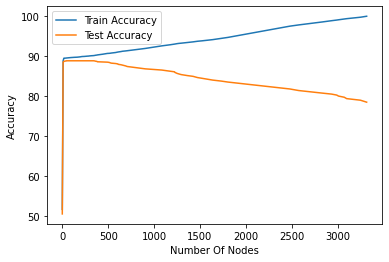

In [25]:
train_acc_track, test_acc_track, nodes_num_track = post_pruning(tree_entropy_gain_ratio)

plt.plot(nodes_num_track,train_acc_track, label="Train Accuracy")
plt.plot(nodes_num_track, test_acc_track, label="Test Accuracy")

plt.xlabel('Number Of Nodes')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

## Chi square pre-pruning

Consider the following p-value cut-off values: [1 (no pruning), 0.5, 0.25, 0.1, 0.05, 0.0001 (max pruning)]. For each value, construct a tree and prune it according to the cut-off value. Next, calculate the training and testing accuracy. On a single plot, draw the training and testing accuracy as a function of the tuple (p-value, tree depth). Mark the best result on the graph with red circle.

In [26]:
### Chi square table values ###
# The first key is the degree of freedom 
# The second key is the p-value cut-off
# The values are the chi-statistic that you need to use in the pruning
chi_table = {1: {0.5 : 0.45,
                 0.25 : 1.32,
                 0.1 : 2.71,
                 0.05 : 3.84,
                 0.0001 : 100000},
             2: {0.5 : 1.39,
                 0.25 : 2.77,
                 0.1 : 4.60,
                 0.05 : 5.99,
                 0.0001 : 100000},
             3: {0.5 : 2.37,
                 0.25 : 4.11,
                 0.1 : 6.25,
                 0.05 : 7.82,
                 0.0001 : 100000},
             4: {0.5 : 3.36,
                 0.25 : 5.38,
                 0.1 : 7.78,
                 0.05 : 9.49,
                 0.0001 : 100000},
             5: {0.5 : 4.35,
                 0.25 : 6.63,
                 0.1 : 9.24,
                 0.05 : 11.07,
                 0.0001 : 100000},
             6: {0.5 : 5.35,
                 0.25 : 7.84,
                 0.1 : 10.64,
                 0.05 : 12.59,
                 0.0001 : 100000},
             7: {0.5 : 6.35,
                 0.25 : 9.04,
                 0.1 : 12.01,
                 0.05 : 14.07,
                 0.0001 : 100000},
             8: {0.5 : 7.34,
                 0.25 : 10.22,
                 0.1 : 13.36,
                 0.05 : 15.51,
                 0.0001 : 100000},
             9: {0.5 : 8.34,
                 0.25 : 11.39,
                 0.1 : 14.68,
                 0.05 : 16.92,
                 0.0001 : 100000},
             10: {0.5 : 9.34,
                  0.25 : 12.55,
                  0.1 : 15.99,
                  0.05 : 18.31,
                  0.0001 : 100000},
             11: {0.5 : 10.34,
                  0.25 : 13.7,
                  0.1 : 17.27,
                  0.05 : 19.68,
                  0.0001 : 100000}}

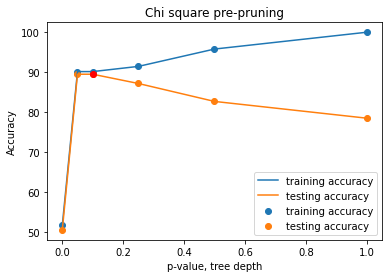

In [31]:
p_values =  [1, 0.5, 0.25, 0.1, 0.05, 0.0001]
training_accur = []
testing_accur  = []
all_trees= []
best_index=0
best_result = np.NINF
best_chi = 0
plt.title('Chi square pre-pruning')
plt.xlabel('p-value, tree depth')
plt.ylabel('Accuracy')

for index,value in enumerate(p_values):
    d_tree = build_tree(X_train, calc_entropy, gain_ratio=True, chi=value)
    training_accur.append(calc_accuracy(d_tree,X_train))
    test_acc =calc_accuracy(d_tree,X_test)
    testing_accur.append(test_acc)
    all_trees.append(d_tree)
    if test_acc > best_result:
      best_result = test_acc
      best_index = index
      best_chi = value

plt.plot(p_values,training_accur,label='training accuracy')
plt.plot(p_values,testing_accur,label='testing accuracy')
plt.scatter(p_values, training_accur, label='training accuracy')
plt.scatter(p_values, testing_accur, label='testing accuracy')

plt.plot(p_values[best_index], best_result, color='red', marker='o')

plt.legend()
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_chi - the best tree according to chi square pruning

In [28]:
tree_post_pruning = build_tree(X_train, calc_entropy, gain_ratio=True)
_=post_pruning(tree_post_pruning)
tree_chi = build_tree(X_train, calc_entropy, gain_ratio=True, chi = best_chi)


## Print the tree

Complete the function `print_tree` and execute it on your chosen tree. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts


In [29]:
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    if node is None:
      return
    if len(node.class_counts) == 1:
      leaf_des = f'{node.class_values[0]}: {node.class_counts[0]}'
    else:
      leaf_des = f'{node.class_values[0]}: {node.class_counts[0]}, {node.class_values[1]}: {node.class_counts[1]}'
    
    if node.feature is None:
        print(" " *2* depth,"[X"+str(parent_feature),"=",feature_val, "leaf]: ==> [",leaf_des,"]")
        return
    if feature_val == 'ROOT':
      print(" " *2* depth,'[ROOT, feature = X'+str(node.feature),"]")
      
    else:
      print(" " *2* depth,'[X'+parent_feature," = ",feature_val,",","feature = X"+str(node.feature),"]")

    for child_branch, child in node.children.items():
        print_tree(child, depth+1, str(node.feature) ,child_branch)


In [30]:
print_tree(tree_chi)

 [ROOT, feature = X4 ]
   [X4 = a leaf]: ==> [ e: 273, p: 31 ]
   [X4 = c leaf]: ==> [ e: 10, p: 137 ]
   [X4  =  f , feature = X10 ]
     [X10  =  f , feature = X2 ]
       [X2 = b leaf]: ==> [ e: 8, p: 30 ]
       [X2 = g leaf]: ==> [ e: 5, p: 26 ]
       [X2 = w leaf]: ==> [ e: 1, p: 35 ]
     [X10 = k leaf]: ==> [ e: 134, p: 1037 ]
     [X10 = s leaf]: ==> [ e: 22, p: 310 ]
   [X4  =  l , feature = X1 ]
     [X1 = f leaf]: ==> [ e: 19, p: 1 ]
     [X1 = s leaf]: ==> [ e: 94, p: 16 ]
     [X1 = y leaf]: ==> [ e: 159, p: 10 ]
   [X4 = m leaf]: ==> [ e: 2, p: 25 ]
   [X4  =  n , feature = X7 ]
     [X7  =  b , feature = X18 ]
       [X18 = b leaf]: ==> [ e: 34, p: 2 ]
       [X18 = k leaf]: ==> [ e: 843, p: 93 ]
       [X18 = n leaf]: ==> [ e: 882, p: 105 ]
       [X18  =  o , feature = X19 ]
         [X19 = c leaf]: ==> [ e: 12, p: 4 ]
         [X19 = v leaf]: ==> [ e: 16 ]
       [X18 = r leaf]: ==> [ e: 6, p: 46 ]
       [X18 = w leaf]: ==> [ e: 369, p: 33 ]
       [X18 = y leaf]: 